# Работа программиста в России и Узбекистане: сравнение зарплат и валютных рисков

Оглавление
1. Введение
2. Предобработка
3. Анализ данных  
  3.1 Какая зарплата больше  
  3.2 Влияние курса рубля на курс сума  
  3.3 Волатильность рубля и сума
4. Выводы  

## 1. Введение
### Цель анализа 
Выяснить, стоит ли программисту менять работу в России на работу в Узбекистане.

### Обзор ситуации
Сейчас программист получает зарплату в рублях. Ему предложили удаленную работу в компании Узбекистана с зарплатой в сумах. Новая зарплата в договоре будет прописана в доларах, а выдаваться в сумах по курсу, зафиксированному на момент заключения трудового договора. Необходимо выяснить, выгодно ли менять работу, учитывая предлагаемые условия и геополитическую ситуацию.

### Описание данных
1. Исторические курсы валют (2020 – 2025 гг.) с сайта investing.com: 10000 UZS/RUB, USD/RUB и USD/UZS. Они содержат следущую информацию:
    * **Date (Дата)** - дата (число, месяц, год).
    * **Price	(Цена)** - цена закрытия индекса (closing price) в момент окончания торгового дня.
    * **Open (Откр.)** - цена открытия индекса в момент начала торгового дня.
    * **High (Макс.)** - максимальное значение индекса за день.
    * **Low (Мин.)** - минимальное значение индекса за день.
    *	**Vol. (Объём)** - объём торгов (общее количество валюты, купленной и проданной за день).
    * **Change % (Изм. %)** - процентное изменение за день относительно предыдущего закрытия.

2. Инфляция:  
    * Россия: 9.52% (2024), 7.5% (прогноз 2025).  
    * Узбекистан: 9.8% (2024), 8.5% (прогноз 2025).   
    * США: 3.2% (2024), 2.5% (прогноз 2025).  

3. Налоги:  
**В России** доход до 5 млн. руб. в год облагается НДФЛ 13%. Свыше 5 млн - 15%.  
**В Узбекистане** доход облагается ПИТ 12%.  
Между Россией и Узбекистаном действует соглашение об избежании двойного налогообложения:  
Сначала налог платится в Узбекистане. Затем в России доплачивается разница между ставками: 13% - 12% = 1%, и на превышение 5 млн 15% - 12% = 3%.

4. Зарплата:  
Текущая зарплата - 430 000 руб после налогов.  
Новая зарплата - 5020 $ после налогов.  
Фиксированный курс UZS/USD: 1 Сум = 0.000077164781 \$.

### План
1. Предобработка данных.
2. Анализ размера зарплат (текущей и новой) сейчас и через год.
3. Изучение влияния курса рубля на курс сума.  
4. Расчет волатильности валют.

## 2. Предобработка
Отобразим данные.  
Посмотрим исторические курсы валют с 1 января 2020 года по 25 марта 2025 года.

In [92]:

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore') # скрываем ненужные предупреждения
import copy

Курс 10000 UZS/RUB:

In [93]:
df_10000UZS_RUB = pd.read_csv(r"E:\Разное\Python\Analysis\Analytics\Work_in_Uzbekistan\10000UZS_RUB.csv")
df_10000UZS_RUB.columns.str.strip()
df_10000UZS_RUB.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,03/25/2025,65.384903,64.782997,65.642250,64.490250,NaN,1.24%
1,03/24/2025,64.583801,65.298599,65.485703,64.458054,NaN,-0.79%
2,03/21/2025,65.096603,65.642601,65.666451,63.946098,NaN,-0.74%


Курс USD/RUB:

In [94]:
df_USD_RUB = pd.read_csv(r"E:\Разное\Python\Analysis\Analytics\Work_in_Uzbekistan\USD_RUB.csv")
df_USD_RUB.columns.str.strip()
df_USD_RUB.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,03/25/2025,84.5246,83.8746,84.935,83.5004,NaN,0.78%
1,03/24/2025,83.8705,84.0000,84.500,83.5000,NaN,-0.74%
2,03/21/2025,84.4955,82.7500,84.875,82.7500,NaN,-0.50%


Курс USD/UZS:

In [95]:
df_USD_UZS = pd.read_csv(r"E:\Разное\Python\Analysis\Analytics\Work_in_Uzbekistan\USD_UZS.csv")
df_USD_UZS.columns.str.strip()
df_USD_UZS.head(3)

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,25.03.2025,"12.960,00","12.983,41","12.983,41","12.923,70",NaN,"0,29%"
1,24.03.2025,"12.922,30","12.940,55","12.976,94","12.903,72",NaN,"0,02%"
2,21.03.2025,"12.920,00","12.937,50","12.957,79","12.932,78",NaN,"-0,02%"


Преобразуем даты к одному виду и объединим таблицы.

In [96]:
df_10000UZS_RUB["Date"] = pd.to_datetime(df_10000UZS_RUB["Date"], format="%m/%d/%Y")
df_USD_RUB["Date"] = pd.to_datetime(df_USD_RUB["Date"], format="%m/%d/%Y")
df_USD_UZS["Дата"] = pd.to_datetime(df_USD_UZS["Дата"], format="%d.%m.%Y")

In [97]:
# Посмотрим, одинаково ли количество строк в данных за один и тот же период.
# Если количество строк разное, в объединенной таблице будут пропущенные значения. 
len(df_10000UZS_RUB), len(df_USD_RUB), len(df_USD_UZS)

(1365, 1366, 1365)

In [98]:
# Объединение данных в одну таблицу
df = pd.merge(df_10000UZS_RUB[["Date", "Price"]], df_USD_RUB[["Date", "Price"]], on="Date", how="outer", suffixes=('_10000UZS/RUB','_USD/RUB'))
df = pd.merge(df, df_USD_UZS[["Дата", "Цена"]], left_on="Date", right_on="Дата", how="outer").drop(columns=["Дата"])
df = df.sort_values(by="Date", ascending=False).reset_index(drop=True)
df.head(3)

,Date,Price_10000UZS/RUB,Price_USD/RUB,Цена
0,2025-03-25,65.384903,84.5246,"12.960,00"
1,2025-03-24,64.583801,83.8705,"12.922,30"
2,2025-03-21,65.096603,84.4955,"12.920,00"


Скорректируем название столбцов и выполним дополнительную конвертацию.

In [99]:
df.columns = ["Date", "10000UZS/RUB", "USD/RUB", "USD/UZS"]
df["UZS/RUB"] = (df["10000UZS/RUB"]/10000).astype(float)
df.style.format({"UZS/RUB": "{:.8f}"})
df["RUB/UZS"] = 1/df["10000UZS/RUB"] * 10000
df["RUB/USD"] = 1/df["USD/RUB"]
df["USD/UZS"] = df["USD/UZS"].str.replace(".", "").str.replace(",", ".").astype(float)
df["UZS/USD"] = 1/df["USD/UZS"]
df = df[["Date", "10000UZS/RUB", "UZS/RUB", "RUB/UZS", "USD/RUB", "RUB/USD", "USD/UZS", "UZS/USD"]]
df.head()

,Date,10000UZS/RUB,UZS/RUB,RUB/UZS,USD/RUB,RUB/USD,USD/UZS,UZS/USD
0,2025-03-25,65.384903,0.006538,152.940504,84.5246,0.011831,12960.0,0.000077
1,2025-03-24,64.583801,0.006458,154.837588,83.8705,0.011923,12922.3,0.000077
2,2025-03-21,65.096603,0.006510,153.617847,84.4955,0.011835,12920.0,0.000077
3,2025-03-20,65.582703,0.006558,152.479229,84.9205,0.011776,12922.6,0.000077
4,2025-03-19,64.929001,0.006493,154.014383,83.9955,0.011905,12908.5,0.000077


В таблице представлены следующие данные:
* **Date** - дата (год, месяц и число).
* **10000UZS/RUB** - количество рублей за 10 000 сумов.
* **UZS/RUB** - количество рублей за 1 сум.
* **RUB/UZS** - количество сумов за 1 рубль.
* **USD/RUB** - количество рублей за 1 доллар.
* **RUB/USD** - количество долларов за 1 рубль.
* **USD/UZS** - количество сумов за 1 доллар.
* **UZS/USD** - количество долларов за 1 сум.

Типы данных в столбцах:

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366 entries, 0 to 1365
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1366 non-null   datetime64[ns]
 1   10000UZS/RUB  1365 non-null   float64       
 2   UZS/RUB       1365 non-null   float64       
 3   RUB/UZS       1365 non-null   float64       
 4   USD/RUB       1366 non-null   float64       
 5   RUB/USD       1366 non-null   float64       
 6   USD/UZS       1365 non-null   float64       
 7   UZS/USD       1365 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 85.5 KB


Все типы данных нас устраивают. 
   
Прверим наличие дубликатов:

In [101]:
df[df.duplicated()]

,Date,10000UZS/RUB,UZS/RUB,RUB/UZS,USD/RUB,RUB/USD,USD/UZS,UZS/USD


Дабликаты отсутствуют.

Изучим пропущенные значения:  

In [102]:
df.columns[df.isna().any(axis=0)]

Index(['10000UZS/RUB', 'UZS/RUB', 'RUB/UZS', 'USD/UZS', 'UZS/USD'], dtype='object')

In [103]:
(int(df["10000UZS/RUB"].isna().sum()), int(df["UZS/RUB"].isna().sum()), int(df["RUB/UZS"].isna().sum()), 
 int(df["USD/UZS"].isna().sum()), int(df["UZS/USD"].isna().sum()))

(1, 1, 1, 1, 1)

In [104]:
df[df["10000UZS/RUB"].isna()]

,Date,10000UZS/RUB,UZS/RUB,RUB/UZS,USD/RUB,RUB/USD,USD/UZS,UZS/USD
1067,2021-02-20,NaN,NaN,NaN,74.048,0.013505,NaN,NaN


Пропуски обнаружены лишь в одной строке таблицы в столбцах '10000UZS/RUB', 'UZS/RUB', 'RUB/UZS', 'USD/UZS', 'UZS/USD'.   
Удалим ее.

In [105]:
df = df.dropna()

Создадим таблицу с данными по инфляции за 2024 год и прогнозом на 2025.

In [106]:
inflation = pd.DataFrame({
    2024: [9.52, 9.8, 3.2],
    2025: [7.5, 8.5, 2.5]
}, index=["Russia", "Uzbekistan", "USA"])
inflation

,2024,2025
Russia,9.52,7.5
Uzbekistan,9.80,8.5
USA,3.20,2.5


Создадим переменные с текущей зарплатой в рублях, новой зарплатой в долларах и курсом UZS/USD на сегодняшний день:

In [107]:
old_salary_RUB = 430000  
new_salary_dollar = 5020 
UZS_to_USD = 0.000077164781 

## 3. Анализ данных
Основная задача - определить, стоит ли менять работу в России на работу в Узбекистане.  
Для ее решения:
* Во-первых, узнаем, какая из зарплат больше сейчас, а какая будет больше через год. Учтем инфляцию и хранение денег в рублях и долларах.
* Во-вторых, определим, влияет ли курс рубля, который сейчас сильно зависит от геополитической ситуации, на курс сума, и насколько сильно.
* В-третьих, посмотрим, насколько сум волатилен по сравнению с рублем.

### 3.1 Какая зарплата больше
Определим, какая из зарплат (старая или новая) больше сейчас и будет больше через год.  
Размер зарплаты дан уже после налогов в Росии и Узбекистане, поэтому учитывать их не будем.  

**Сначала разберемся со старой зарплатой.**  
Старая зарплата в рублях сейчас - 430000 руб.  
Старая зарплата в долларах сейчас:

In [108]:
# Предположим, что мы хотим воспользоваться валютным счетом в Сбербанке. Для этого мы покупаем валюту онлайн. 
# Курс на сайте http://www.sberbank.ru/ru/quotes/currencies?tab=sbol
dollar_buying_rate_for_rubles = 86
old_salary_dollar = (old_salary_RUB / dollar_buying_rate_for_rubles)
old_salary_dollar

5000.0

Старая зарплата в рублях с учетом инфляции через год:

In [109]:
old_salary_RUB_1year = int(old_salary_RUB * (100 - inflation.loc["Russia", 2025])/100)
old_salary_RUB_1year

397750

Старая зарплата в долларах с учетом инфляции через год:

In [110]:
# Предположим, что деньги хранились в долларах.
old_salary_dollar_1year = int(old_salary_dollar * (100 - inflation.loc["USA", 2025])/100)
old_salary_dollar_1year

4875

Расчеты по старой зарплате выглядят так:

In [111]:
old_salary = pd.DataFrame({
    "RUB": [old_salary_RUB, old_salary_RUB_1year],
    "USD": [old_salary_dollar, old_salary_dollar_1year]
}, index=["Сейчас", "Через год"])
old_salary

,RUB,USD
Сейчас,430000,5000.0
Через год,397750,4875.0


**Рассчитаем новую зарплату.**    
Зарплата будет выдаваться в сумах по курсу доллара, зафиксированному на момент заключения договора.   
При этом надо учесть, что курс у покупки доллара другой, поэтому фактическая зарплата в долларах будет отличаться от обещанной.  
   
Новая зарплата в сумах сейчас:

In [112]:
new_salary_som = new_salary_dollar * 1/UZS_to_USD
new_salary_som

65055585.397177495

Новая зарплата в долларах сейчас:

In [113]:
# Предположим, что у нас есть карта в Национальном банке Узбекистана (NBU) и мы хотим, чтобы на ней лежали доллары.  
# Для этого конвертируем UZS в USD по курсу банка NBU. 
# Курс на сайте https://nbu.uz/jismoniy-shaxslar-valyutalar-kursi
dollar_buying_rate_for_soms = 12980.00
new_salary_dollar = new_salary_som / dollar_buying_rate_for_soms
new_salary_dollar

5011.98654831876

Новая зарплата в рублях сейчас:

In [114]:
# Предположим, что у нас есть карта в Национальном банке Узбекистана (NBU) и мы хотим, чтобы на ней лежали рубли.  
# Для этого конвертируем UZS в RUB по курсу банка NBU. 
# Курс на сайте https://nbu.uz/jismoniy-shaxslar-valyutalar-kursi
RUB_buying_rate_for_soms = 157.00
new_salary_RUB = new_salary_som / RUB_buying_rate_for_soms
new_salary_RUB

414366.78596928343

Новая зарплата в рублях с учетом инфляции через год:

In [115]:
# Предположим, что деньги хранились в рублях.
new_salary_RUB_1year = int(new_salary_RUB * (100 - inflation.loc["Russia", 2025])/100)
new_salary_RUB_1year

383289

Новая зарплата в долларах с учетом инфляции через год:

In [116]:
# Предположим, что деньги хранились в долларах.
new_salary_dollar_1year = int(new_salary_dollar * (100 - inflation.loc["USA", 2025])/100)
new_salary_dollar_1year

4886

Расчеты по новой зарплате выглядят так:

In [117]:
new_salary = pd.DataFrame({
    "RUB": [new_salary_RUB, new_salary_RUB_1year],
    "USD": [new_salary_dollar, new_salary_dollar_1year]
}, index=["Сейчас", "Через год"])
new_salary

,RUB,USD
Сейчас,414366.785969,5011.986548
Через год,383289.000000,4886.000000


**Вывод:**  
При хранении в долларах выигрывает новая зарплата — и сейчас, и через год.  
При хранении в рублях в обоих случаях больше оказывается старая зарплата.

### 3.2 Влияние курса рубля на курс сума
Сейчас у России складывается сложная геополитическая ситуация. Основные причины - это военный конфликт с Украиной, санкционное давление со стороны западных стран и ограниченное международное сотрудничество. Все это оказывает влияние на курс рубля.  

Нам важно понять, влияет ли курс рубля, на курс сума и, если да, то в какой степени.  

Если сум не зависит или слабо зависит от рубля, то получение зарплаты в сумах будет более надежным.   

Чтобы проверить это, необходимо:  
1. Определить, какие именно данные мы будем использовать для оценки курса рубля и сума.
2. Построить графики рубля и сума с течением времени. Это позволит нам посмотреть, какие исторические события одинаково влияли на обе валюты, а которые лишь на одну.
3. Определить наличие, размер и направление связи между валютами.

#### 3.2-1 Данные для оценки курса рубля и сума
Возьмем рубль. Как оценить его размер с течением времени? Валюты не имеют абсолютной стоимости, они сравниваются друг с другом через обменные курсы. Поэтому необходимо выбрать валюту, по отношению к которой мы будем оценивать рубль.

Есть 2 способа, позволяющих сделать это:
1. Использовать курс USD/RUB. Доллар считается мировой резервной валютой, поэтому чаще всего используют его.
2. Использовать валютную корзину - набор валют, по отношению к которому определяется средневзвешенный курс одной валюты. Обычно в валютную корзину включают доллар США, марку ФРГ, японскую иену, французский франк и английский фунт стерлингов.

Мы будем использовать первый способ, поскольку у нас уже есть необходимые данные, он быстрее и его достаточно для наших целей.

#### 3.2-2 Рубль и сум с течением времени
Построим графики курса рубля и сума с течением времени. По оси x будет время, а по оси y - курсы USD/RUB и USD/UZS.  
Для удобного сравнения сопоставим масштабы.

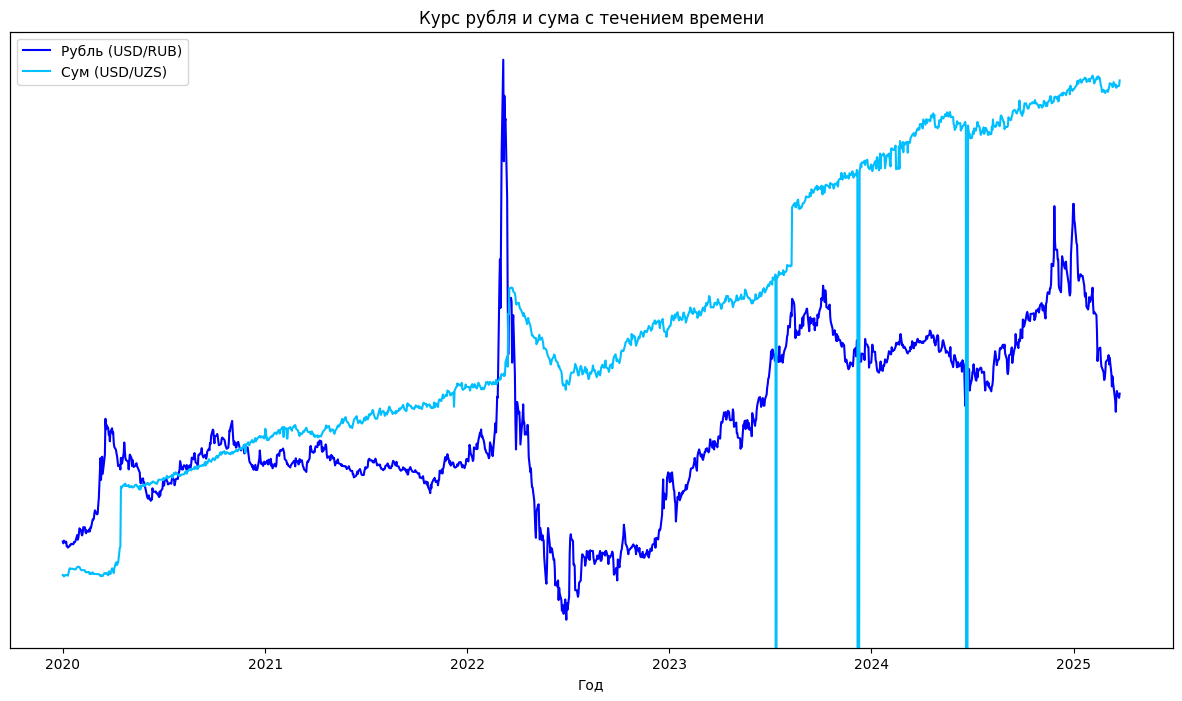

In [118]:
fig, ax1 = plt.subplots(figsize=(15, 8))

# Курс рубля (USD/RUB)
line1, = ax1.plot(df["Date"], df["USD/RUB"], label="Рубль (USD/RUB)", color='blue')
ax1.set_xlabel("Год")
ax1.yaxis.set_ticks([])

# Курс сума (USD/UZS)
ax2 = ax1.twinx()
line2, = ax2.plot(df["Date"], df["USD/UZS"], label="Сум (USD/UZS)", color='DeepSkyBlue')
ax2.set_ylim(9000, 13300)
ax2.yaxis.set_ticks([])

# Добавляем легенду
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title("Курс рубля и сума с течением времени")
plt.show()

Из графика видно следующее:  
    
1. С течением времени рубль и сум падают по отношению к доллару. 
     
2. В 2022 году можно наблюдать резкий скачок и падение USD/RUB, а затем плавный подъем вплоть до конца 2023 года. Это означает ослабление рубля, затем укрепление и вновь постепенное ослабление. Резкое ослабление связано с началом конфликта с Украиной, санкциями. Укрепление - результат валютного контроля ЦБ. Дальнейшее падение - рост импорта, падение цен на нефть, уход компаний.  
В это же время можно наблюдать аналогичную картину USD/UZS. Причины - конфликт России с Украиной, скупка валюты, паника, миграция людей и капитала. Постепенное укрепление - результат адаптации экономики.   
  
3. Во второй половине 2023 года USD/RUB подскочил (рубль упал), но потом курс стабилизировался. Падение рубля вновь связано с санкциями, а укрепление - с повышением ключевой ставки рубля, прекращением покупки и увеличением продажи иностранной валюты, ростом цен на нефть.  
В это время также можно наблюдать рост USD/UZS (падение сума). Это произошло из-за ослабления рубля и увеличения импорта.  
  
4. В начале 2025 года заметны скачки USD/RUB (ослабление рубля). Причина - санкции, снижение выручки от экспорта. При этом USD/UZS соответствующим образом не изменялся.
   
5. С середины 2023 по середину 2024 USD/UZS 3 раза резко падал:

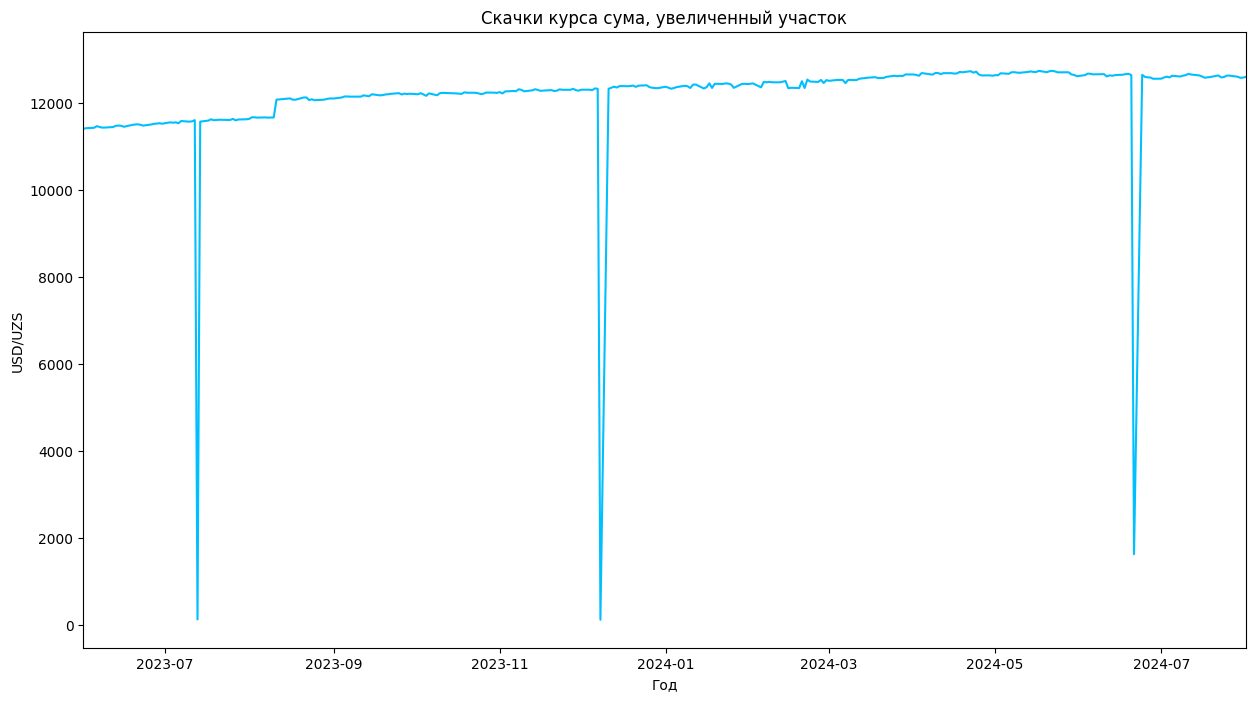

In [119]:
plt.figure (figsize=(15, 8))

# Курс сума (USD/UZS)
plt.plot(df["Date"], df["USD/UZS"], label="Сум (USD/UZS)", color='DeepSkyBlue')
plt.xlim(pd.to_datetime("2023-06-01"), pd.to_datetime("2024-08-01"))
plt.xlabel ("Год")
plt.ylabel("USD/UZS")

plt.title("Скачки курса сума, увеличенный участок")
plt.show()

Эти скачки связаны с интервенцией ЦБ Узбекистана (ЦБ может продавать доллары из резервов, чтобы укрепить сум и стабилизировать экономику). Курс USD/RUB во время этих скачков значительно не менялся.

**Вывод:**  
1. Начало конфликта между Россией и Украиной оказало заметное негативное влияние как на курс рубля, так и на курс сума. Колебания в конце 2023 года также свидетельствуют о возможной зависимости курса сума от динамики рубля. Однако в начале 2025 года эта связь уже не прослеживается.  
2. Обратной зависимости - влияния курса сума на рубль, выявлено не было.

#### 3.2-3 Зависимость сума от рубля
Изучим, есть ли связь между курсами рубля и сума, а также влияет ли курс рубля на сум. Для этого будем использовать 3 метода: корреляция, линейная регрессия и тест Грейнджера.  
  
##### 3.2-3-1 Корреляция   
Чтобы определить, какова связь между рублем и сумом, воспользуемся корреляцией.
Вновь возьмем курсы USD/RUB и USD/UZS.  
Построим диаграмму рассеяния. Она покажет, есть ли линейная связь между переменными и наличие выбросов. Это позволит нам выбрать коэффициент корреляции. 

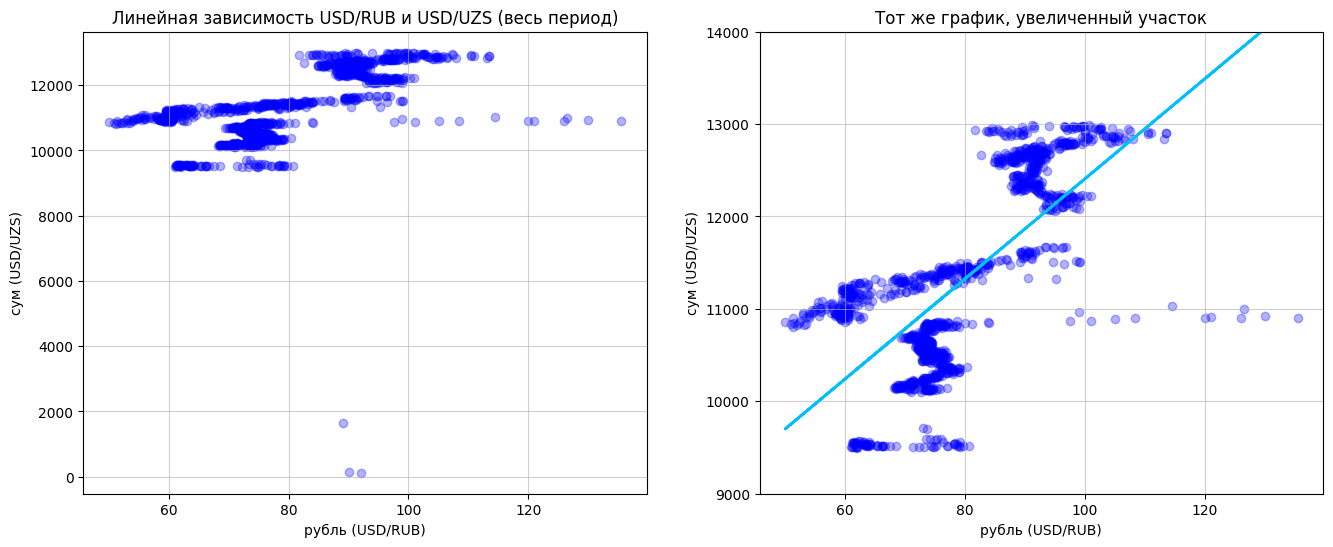

In [120]:
x = df["USD/RUB"]
y = df["USD/UZS"]

#Левый график
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x, y, alpha=0.3, color="blue")
plt.xlabel('рубль (USD/RUB)')
plt.ylabel('сум (USD/UZS)')
plt.title('Линейная зависимость USD/RUB и USD/UZS (весь период)')
plt.grid(True, alpha=0.6)

#Правый график
plt.subplot(1,2,2)
plt.scatter(x, y, alpha=0.3, color="blue")
#Линия тренда
coeffs = np.polyfit(x, y, deg=1) 
trend = np.poly1d(coeffs) 
plt.plot(x, trend(x), color="DeepSkyBlue", linewidth=2, label="Линия тренда") 
plt.xlabel('рубль (USD/RUB)')
plt.ylabel('сум (USD/UZS)')
plt.ylim (9000, 14000)
plt.title('Тот же график, увеличенный участок')
plt.grid(True, alpha=0.6)
plt.show()

Видно, что значение USD/RUB c 2020 года по настоящее время в основном варьируется от 50 до 110, а USD/UZS - от 9500 до 13000. Линию тренда провести можно, однако разброс точек большой и четкой линейной зависимости не видно. Есть выбросы. Для расчета корреляции будем использовать коэффициент Спирмена.

In [121]:
r_spearman, p_value_spearman = spearmanr(df["USD/RUB"], df["USD/UZS"])
print(f"Коэффициент корреляции Спирмена: {r_spearman:.3f}")
print(f"p-value: {p_value_spearman:.5f}")

Коэффициент корреляции Спирмена: 0.666
p-value: 0.00000


p-value < 0.05, корреляция значима, ее маловероятно получить случайно. Связь между курсами USD/RUB и USD/UZS сильная положительная (0,7). Это означает, что, когда рубль падает, сум также падает и наоборот. Однако это не значит, что сум падает из-за того, что падает рубль.  
  
**Вывод:**  
Курсы рубля и сума сильно связаны.

##### 3.2-3-2 Простая линейная регрессия  
Оценим вклад курса рубля в формирование курса сума с помощью простой линейной регрессии. Используем курсы USD/RUB и USD/UZS.  
Нулевая гипотеза H₀ звучит так:  
*Курс рубля (USD/RUB) не влияет на курс сума (USD/UZS).*  

In [122]:
# Выделяем X и y 
# X — независимая переменная (курс рубля)
# y — зависимая переменная (курс сума)
X = sm.add_constant(df['USD/RUB'])
y = df['USD/UZS']

# Строим и обучаем модель 
model = sm.OLS(y, X).fit()

r2 = model.rsquared
p_value = model.pvalues['USD/RUB']

#print(model.summary())
print("Коэффициент детерминации R²:", round(r2,5))
print("p-value для USD/RUB:", round(p_value,5))

Коэффициент детерминации R²: 0.38607
p-value для USD/RUB: 0.0


p-value < 0.05, переменная X влияет на y, отклоняем H₀ → курс рубля влияет на курс сума.  
R² = 38.6% значит, что 38.6% изменений курса сума (USD/UZS) можно объяснить изменениями курса рубля (USD/RUB). Иными словами 38.6% движений курса сума связаны с движениями курса рубля, а 61.4% — с другими причинами.  

Ничто не доказывает, что рубль — причина изменений курса сума. Обе валюты могут слабеть из-за общих факторов. Важно отделить влияние рубля от других возможных причин. Для этого используем тест Грейнджера.  
  
**Вывод:**   
38.6% движений курса сума связаны с движениями курса рубля.   
   
##### 3.2-3-3 Тест Грейнджера
Тест Грейнджера проверяет, помогают ли ранние значения курса рубля (например, вчера, позавчера) предсказывать курс сума сегодня.  
Будем использовать курсы USD/RUB и USD/UZS с проверкой до 5 дней назад.

In [123]:
results = grangercausalitytests(df[['USD/UZS', 'USD/RUB']], maxlag=5, verbose=True) 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=128.2868, p=0.0000  , df_denom=1361, df_num=1
ssr based chi2 test:   chi2=128.5696, p=0.0000  , df=1
likelihood ratio test: chi2=122.8659, p=0.0000  , df=1
parameter F test:         F=128.2868, p=0.0000  , df_denom=1361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=26.0969 , p=0.0000  , df_denom=1358, df_num=2
ssr based chi2 test:   chi2=52.3859 , p=0.0000  , df=2
likelihood ratio test: chi2=51.4043 , p=0.0000  , df=2
parameter F test:         F=26.0969 , p=0.0000  , df_denom=1358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1449  , p=0.0000  , df_denom=1355, df_num=3
ssr based chi2 test:   chi2=27.5765 , p=0.0000  , df=3
likelihood ratio test: chi2=27.3011 , p=0.0000  , df=3
parameter F test:         F=9.1449  , p=0.0000  , df_denom=1355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1671  , p=0.

p-value < 0.05, рубль (USD/RUB) помогает предсказывать сум (USD/UZS) → рубль может быть причиной изменения курса сума.

In [124]:
results = grangercausalitytests(df[['USD/RUB', 'USD/UZS']], maxlag=5, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6442  , p=0.0033  , df_denom=1361, df_num=1
ssr based chi2 test:   chi2=8.6633  , p=0.0032  , df=1
likelihood ratio test: chi2=8.6359  , p=0.0033  , df=1
parameter F test:         F=8.6442  , p=0.0033  , df_denom=1361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4497  , p=0.0002  , df_denom=1358, df_num=2
ssr based chi2 test:   chi2=16.9616 , p=0.0002  , df=2
likelihood ratio test: chi2=16.8570 , p=0.0002  , df=2
parameter F test:         F=8.4497  , p=0.0002  , df_denom=1358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5661  , p=0.0009  , df_denom=1355, df_num=3
ssr based chi2 test:   chi2=16.7846 , p=0.0008  , df=3
likelihood ratio test: chi2=16.6820 , p=0.0008  , df=3
parameter F test:         F=5.5661  , p=0.0009  , df_denom=1355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4800  , p=0.

p-value < 0.05, сум (USD/UZS) помогает предсказывать рубль (USD/RUB), то есть сум тоже влияет на рубль.    
Тесты показывают взаимное влияние рубля и сума.  
  
Чтобы оценить, какая валюта влияет сильнее, сравним F-статистики при лаге 1. Они показывают, как курс одной валюты вчера повлиял на другую сегодня:  
Первый тест (рубль → сум): F = 128.29  
Второй тест (сум → рубль): F = 8.64   
F-статистика для первого теста больше. Влияние рубля на сум в разы сильнее, чем сума на рубль.  
  
**Вывод:**   
Рубль является причиной изменения курса сума. Конечно, на него влияют и другие факторы, но вклад рубля может достигать 38,6%.

### 3.3 Волатильность рубля и сума
Волатильность — это мера того, насколько сильно и часто меняется курс валюты. Волатильности рубля и сума важны для принятия решения о смене работы. Если выяснится, что сум более волатилен, то работа в России будет более стабильным вариантом, и наоборот.  
Для расчетов будем использовать курсы USD/RUB и USD/UZS:

In [125]:
volatility = copy.deepcopy(df)
del volatility["10000UZS/RUB"]
del volatility["UZS/RUB"]
del volatility["RUB/UZS"]
del volatility["RUB/USD"]
del volatility["UZS/USD"]
volatility.head()

,Date,USD/RUB,USD/UZS
0,2025-03-25,84.5246,12960.0
1,2025-03-24,83.8705,12922.3
2,2025-03-21,84.4955,12920.0
3,2025-03-20,84.9205,12922.6
4,2025-03-19,83.9955,12908.5


Волатильность рассчитывается как стандартное отклонение процентных изменений курса валюты, умноженное на $\sqrt{252}$.  
252 — это примерное число торговых дней в году, а корень используется потому, что волатильность со временем растёт не линейно, а пропорционально корню из числа дней.  
  
Для корректного расчета стандартного отклонения сума необходимо убрать выбросы - скачки, связанные с интервенцией ЦБ Узбекистана. Найдем на графике даты этих скачков:

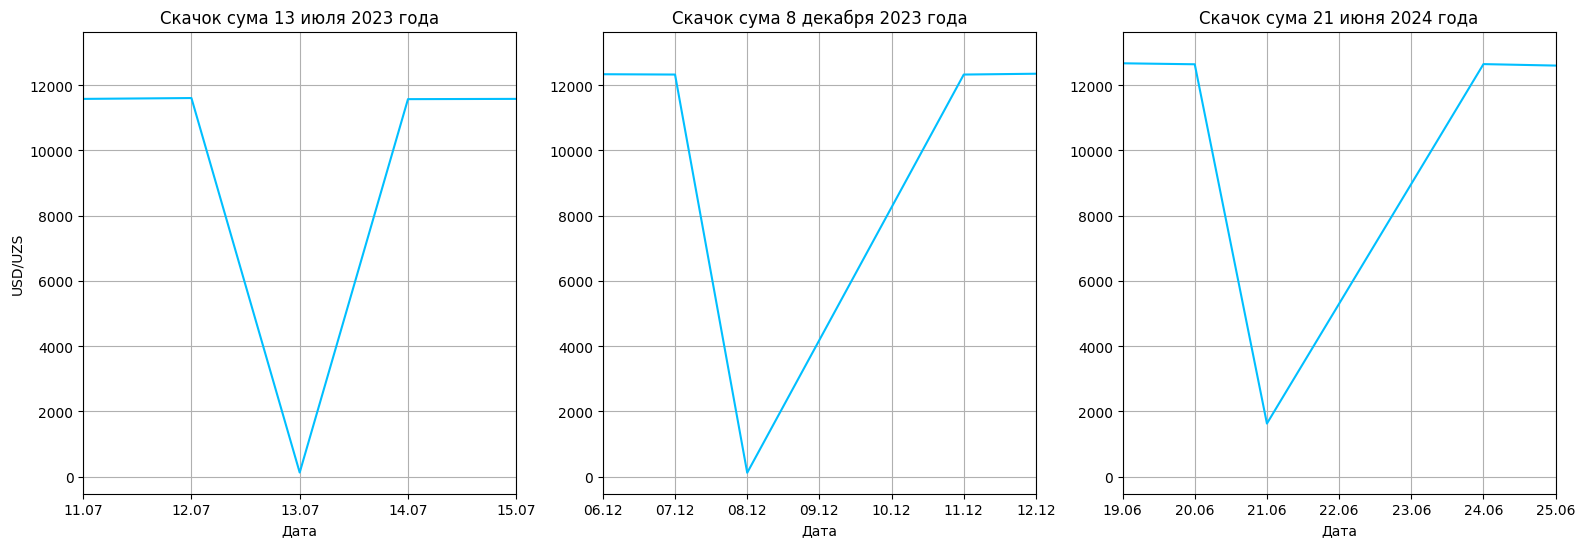

In [126]:
#Скачок сума 13 июля 2023 года
plt.figure(figsize=(19,6))
plt.subplot(1,3,1)
plt.plot(df["Date"], df["USD/UZS"], label="Сум (USD/UZS)", color='DeepSkyBlue')
date_format = mdates.DateFormatter('%d.%m')
ax = plt.gca()
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.xlim(pd.to_datetime("2023-07-11"), pd.to_datetime("2023-07-15"))
plt.xlabel ("Дата")
plt.ylabel("USD/UZS")
plt.grid()
plt.title("Скачок сума 13 июля 2023 года")

#Скачок сума 8 декабря 2023 года
plt.subplot(1,3,2)
plt.plot(df["Date"], df["USD/UZS"], label="Сум (USD/UZS)", color='DeepSkyBlue')
date_format = mdates.DateFormatter('%d.%m')
ax = plt.gca()
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xlim(pd.to_datetime("2023-12-06"), pd.to_datetime("2023-12-12"))
plt.xlabel ("Дата")
#plt.ylabel("USD/UZS")
plt.grid()
plt.title("Скачок сума 8 декабря 2023 года")

#Скачок сума 21 июня 2024 года
plt.subplot(1,3,3)
plt.plot(df["Date"], df["USD/UZS"], label="Сум (USD/UZS)", color='DeepSkyBlue')
date_format = mdates.DateFormatter('%d.%m')
ax = plt.gca()
plt.gca().xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xlim(pd.to_datetime("2024-06-19"), pd.to_datetime("2024-06-25"))
plt.xlabel ("Дата")
#plt.ylabel("USD/UZS")
plt.grid()
plt.title("Скачок сума 21 июня 2024 года")
plt.show()

Удалим данные для дат:
* с 2023-07-12 по 2023-07-14;
* с 2023-12-07 по 2023-12-11;
* с 2024-06-21 по 2024-06-24.

In [127]:
volatility = volatility[~volatility['Date'].isin([
    '2023-07-12','2023-07-13', '2023-07-14', 
    '2023-12-07', '2023-12-08', '2023-12-09', 
    '2023-12-10', '2023-12-11', '2024-06-20', 
    '2024-06-21', '2024-06-22', '2024-06-23', 
    '2024-06-24'])]

Сначала посчитаем волатильность рубля и сума за все время: с 1 января 2020 года по 25 марта 2025 года.

In [128]:
# Рассчитываем процентные изменения
volatility['RUB_change'] = volatility['USD/RUB'].pct_change()  
volatility['UZS_change'] = volatility['USD/UZS'].pct_change()  
volatility = volatility.dropna().reset_index(drop="True")

# Рассчитываем волатильность
volatility_rub = volatility['RUB_change'].std() * np.sqrt(252) * 100 
volatility_uzs = volatility['UZS_change'].std() * np.sqrt(252) * 100 

print(f"Волатильность рубля: {volatility_rub:.2f}")
print(f"Волатильность сума: {volatility_uzs:.2f}")

Волатильность рубля: 29.03
Волатильность сума: 4.24


**Волатильность рубля** на уровне 29% означает, что в течение года его курс может колебаться на ±29% с вероятностью около 68%.  
Почему именно 68%? Потому что при нормальном распределении примерно столько значений укладываются в диапазон одного стандартного отклонения от среднего.  
Например, если курс USD/RUB сейчас 82 рубля, он может колебаться в пределах от 58 до 106 рублей.  
Такой уровень волатильности говорит о значительной нестабильности рубля.  
  
**Волатильность сума** значительно ниже — в среднем около 4% в год.  
Это значит, что при текущем курсе USD/UZS 12935 сумов с вероятностью 68% курс останется в диапазоне от 12417 до 13453 сумов.  
Такая волатильность считается низкой — курс сума относительно стабилен.  

Посчитаем волатильность до начала конфликта России с Украиной 24 февраля 2022 года:

In [129]:
filtered_volatility = volatility[volatility['Date'] < '2022-02-24']

volatility_rub = filtered_volatility['RUB_change'].std() * np.sqrt(252) * 100 # волатильность рубля
volatility_uzs = filtered_volatility['UZS_change'].std() * np.sqrt(252) * 100  # волатильность сума

print(f"Волатильность рубля: {volatility_rub:.2f}")
print(f"Волатильность сума: {volatility_uzs:.2f}")

Волатильность рубля: 15.76
Волатильность сума: 3.79


А также волатильность после начала конфликта:

In [130]:
filtered_volatility = volatility[volatility['Date'] >= '2022-02-24']

volatility_rub = filtered_volatility['RUB_change'].std() * np.sqrt(252) * 100 # волатильность рубля
volatility_uzs = filtered_volatility['UZS_change'].std() * np.sqrt(252) * 100  # волатильность сума

print(f"Волатильность рубля: {volatility_rub:.2f}")
print(f"Волатильность сума: {volatility_uzs:.2f}")

Волатильность рубля: 35.54
Волатильность сума: 4.53


Волатильность рубля после начала конфликта России и Украины выросла на 20%, а волатильность сума - всего на 1%.  
   
**Вывод:**  
В целом рубль более волатилен, чем сум: до начала конфликта с Украиной его волатильность превышала волатильность сума в четыре раза, а после — уже в восемь. На этом фоне зарплата в сумах - более стабильный и надёжный вариант.

# 4. Выводы 
1. Доходность зависит от валюты хранения и места получения зарплаты:
    * При хранении в долларах выигрывает новая зарплата — как в текущий момент, так и через год.   
    * При хранении в рублях в обоих случаях больше оказывается старая зарплата.   
  
2. Курс сума частично определяется курсом рубля: его вклад может достигать 38,6%.
  
3. Рубль волатильнее сума:  
До начала конфликта с Украиной волатильность рубля была в 4 раза выше, чем у сума, а после — стала в 8 раз. Рубль уже был менее стабильным, а конфликт усугубил эту ситуацию. На этом фоне получение зарплаты в сумах — более устойчивый вариант.
  
**Итог**   
1. Работа в Узбекистане выглядит надежнее с точки зрения финансовой стабильности.  
2. Для снижения рисков сбережения лучше хранить в долларах.